# Assignment 2 - Q3(Programming Exercise)
#### Bishal Chaulahain, Nishan Nepal, Shristi Heuju, Sushant Gautam

In [56]:
import numpy as np  #used for square-root, power and linear space divison function
import scipy.integrate as integrate # uses a technique from the Fortran library QUADPACK
from numpy import genfromtxt #to parse Anil K Jain table from CSV
import math #for trunc function 
import matplotlib.pyplot as plt; import matplotlib # for beautiful plots 
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams['figure.figsize'] = 10, 8

The general form of its probability density function is:
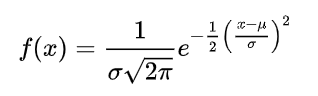

In [57]:
def normal_dist(x, mean=0.0, vari=1.0):
    """
    PDF of normal distribution function
    
    Parameters:
    x: Input
    mean : mean
    vari : variance
    
    Returns:
    float : f(x) as in PDF forumla 
    
    
    """
    return (1.0/(np.sqrt(2.0*np.pi*vari)))*np.exp((-np.power((x-mean),2.0))/(2.0*vari))

In [58]:
from scipy.optimize import minimize
def MSEintegrand(x, xVal):
    """
    Mean Square Error sigma in Lyoid-Max Algorithm. This function is used in integration
    
    Parameters:
    x: integration variable
    xVal : quantization level for which MSE is calculated on the Lyoid-Max Algorithm
    
    Returns:
    float : MS Error
    """
    return  ((x- xVal)**2) * normal_dist(x)

def functionToMinimize(x, minn, maxx):
    """
    This function is used in Nelder-Mead minimization. This returns integtated MSE over the interval minn and maxx

    """
    return  integrate.quad(MSEintegrand, minn, maxx, x)[0]

In [59]:
def yUpdateNumerator(x):
    """
    This function is Numerator in y Update step of Lyoid-Max Algorithm

    """
    return  x * normal_dist(x)

def yUpdateDenominator  (x):
    """
    This function is Denominator in y Update step of Lyoid-Max Algorithm

    """
    return  normal_dist(x)

def yUpdate(lower, upper):
    """
    This function is y Update step of Lyoid-Max Algorithm
    """
    return integrate.quad( yUpdateNumerator,lower, upper,)[0]\
                                     /integrate.quad( yUpdateDenominator,lower, upper,)[0]

In [60]:
def UniformQuantizer(x, UQntType='Mid'):
    """
    This is generic function that implements Uniform Quantization. 
    
    Parameters:
    x: Boundary values 
    UQntType : can be used to choose variants of Uniform Quantizer. Default is 'Mid'.
    
    Returns:
    List : List of dictionary containing quantized level value and boundary values (from and to)
        
    """
    if UQntType == 'Mid': #midtread
        return [{"from": x[i], "to": x[i+1], "value":( x[i]+ x[i+1])/2, } for i in range(len(x)-1)]
    elif UQntType == 'Max': #takes the quantized level value as the starting value of boundary 
        return [{"from": x[i], "to": x[i+1], "value":x[i], } for i in range(len(x)-1)]
    elif UQntType == 'Min': #akes the quantized level value as the closing value of the boundary
        return [{"from": x[i], "to": x[i+1], "value":x[i+1], } for i in range(len(x)-1)]
    
    elif UQntType == 'MidStep':
        MidStep = [{"from": x[i], "to": x[i+1], "MidStep":(normal_dist(x[i])+ normal_dist(x[i+1]))/2} for i in range(len(x)-1)]
        justGreaterThan = []
        for i in MidStep:
            allValuesBetweenY = np.linspace(normal_dist(i['from']), normal_dist(i['to']), 1000)
            allValuesBetweenX = list(np.linspace(i['from'], i['to'], 1000))
            indeX = np.where(allValuesBetweenY>= i['MidStep'])[0]
            indeX = indeX[math.trunc(len(indeX)/2)]

            justGreaterThan.append(allValuesBetweenX[indeX])        
        return [{"from": x[i], "to": x[i+1], "value":justGreaterThan[i], } for i in range(len(x)-1)]
    
    elif UQntType == 'OptimumNelder': # to compete with Jain's using Nelder-Mead's minimization
        return [{"from": x[i], "to": x[i+1], "value":minimize(functionToMinimize, x0=0, args=(x[i],x[i+1]),\
                                                              method='Nelder-Mead',).x[0], } for i in range(len(x)-1)]
    
    elif UQntType == 'OptimumYllyod': # to compete with Jain's..  using Llyod Max's y update function
        return [{"from": x[i], "to": x[i+1], "value":yUpdate(x[i], x[i+1]), } for i in range(len(x)-1)]

In [61]:
def LyoidMax(x, yquant):
    """
    This is function that implements Lyoid-Max Non Uniform Quantization. 
    
    Parameters:
    x: Boundary values 
    yquant : quantized value from Uniform Quantization.
    
    Returns:
    List : List of dictionary containing quantized level value and boundary values (from and to)
        
    """
    y =  [e['value'] for e in yquant]
    threshold = 0.00001
    print(".", end ="") #progress for each 
    b, sigma=  [ x[e] for e in range(len(x))] , 10000

    c=0
    while True and c < 300: #loop will break around 300 if cant reak threshold
        c+=1
        for i in  range(1, len(y)):
            b[i]= (y[i-1]+ y[i])/2 
        sigma = sum([integrate.quad(MSEintegrand, b[i], b[i+1], y[i])[0] for i in range(len(x)-1)])
        if sigma < threshold: print('break'); break
        y=[yUpdate(b[i], b[i+1]) for i in range(len(x)-1)]
    toReturn=[]
    for i, e in enumerate(y):
        toReturn.append({"value":e , "from":b[i] , "to":b[i+1]})
    return toReturn, b, [normal_dist(e) for e in b]

## (a) Assume the variance to be one and plot the PDF of a zero-mean Gaussian random variable.

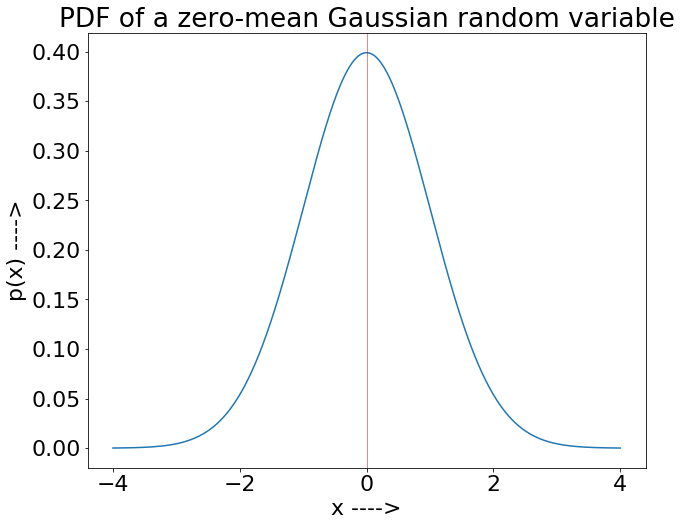

In [62]:
def PlotGaussian():
    """
    Utility function to plot gaussian curve
    """
    plt.plot(np.linspace(-4, 4, 1000 ),  [normal_dist(i) for i in np.linspace(-4, 4, 1000 )],  label='gaussian curve')
    plt.xlabel('x ---->') ; plt.ylabel('p(x) ---->')
    plt.title('PDF of a zero-mean Gaussian random variable')
    plt.axvline(x=0, color="red", linewidth=0.5) #mean
PlotGaussian()

## (b-1) Apply a Uniform Quantizer to the PDF in (a). Make a new figure showing the decision boundaries and reconstruction levels superimposed on the PDF of (a).

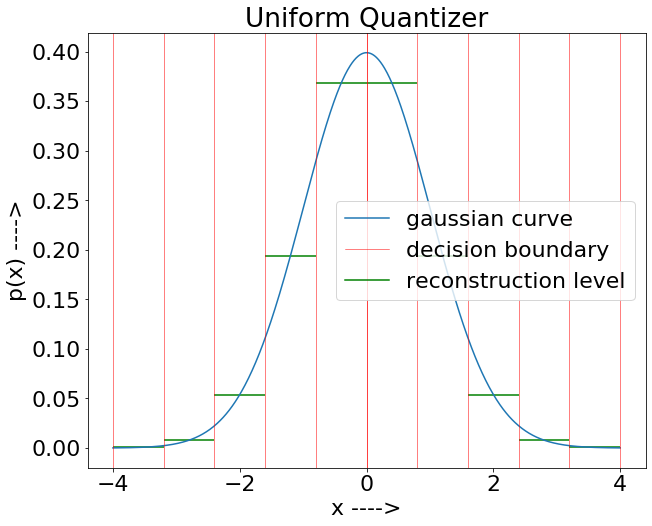

In [84]:
def Quantizer(LyoidMaxAlgorithm=False, label=None, levelToDraw=10, UQntType='Mid'):
    """
    This is a generic function that implements Quantization.
    
    
    Parameters:
    LyoidMaxAlgorithm:  Default is false and does uniform quantization. If true selects LyoidMax Algorithm with non uniform quantization.
    label : Label for plot
    levelToDraw: quantization levels for which the plot is plotted
    UQntType: this chooses uniform quantization type and passes the same value to UniformQuantizer as same parameter.
    
    Returns:
    List : List of dictionary containing quantization levels and MSE Error Data for each quantization levels
        
    """
    Data =[]
    for m in range(1, 32, 1):
        M=m #Number of quantization levels
        Xmin, Xmax = -4, 4
        x= np.linspace(Xmin,Xmax, M+1 ) #evenly spaced M samples over a specified interval.
        y = [normal_dist(i) for i in np.linspace(Xmin,Xmax, M+1 )] #  #quant levels
        yqant = UniformQuantizer(x, UQntType=UQntType) #quantized data
        if LyoidMaxAlgorithm: yqant,x, y = LyoidMax(x, yqant) #  run LyoidMaxAlgorithm only if variable is set True
        QuantError = sum([integrate.quad(MSEintegrand, v['from'], v['to'], v['value'])[0] for v in yqant]) #sum of MSE
        Data.append({"error" :QuantError, "M": M, "LyoidMaxAlgorithm": yqant}) #save the error log for plotting 

        if M==levelToDraw: # this condition is only only once so only one graph is plotted
            PlotGaussian()
            for i in x: plt.axvline(x=i, color="red", linewidth=0.5,) # horizontal lines representing levels
            plt.plot(0, 0,color="red",linewidth=0.5, label='decision boundary') #just for legend            
            for i in yqant: plt.hlines(y = normal_dist(i['value']), xmin=i['from'], xmax=i['to'], color="green") #quant level
            plt.plot(0, 0,color="green", label='reconstruction level') #just for legend
            
            plt.xlabel('x ---->') ; plt.ylabel('p(x) ---->')
            plt.title(label)
            plt.legend() ; plt.show()
    return Data
uniQuantizerData = Quantizer(label="Uniform Quantizer")

## (b-1) Vary the number of decision boundaries and plot the quantization error versus the number of quantization levels

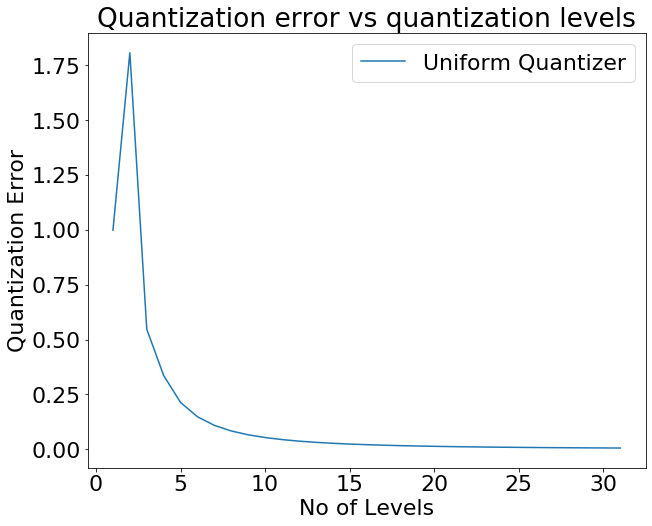

In [85]:
def PlotData(data, label, xlim=None):
    """
    Unility function to plot data with given level and x-axis limits.
    """
    plt.plot([e['M'] for e in data], [e['error'] for e in data],label=label )
    plt.xlabel('No of Levels')
    plt.ylabel('Quantization Error')
    plt.title('Quantization error vs quantization levels')
    if xlim: plt.xlim(xlim)
    plt.legend() ; plt.show()
PlotData(uniQuantizerData, label="Uniform Quantizer")

### Observation
The uniform quantizer's error is increased while going from L=1 to L=2.


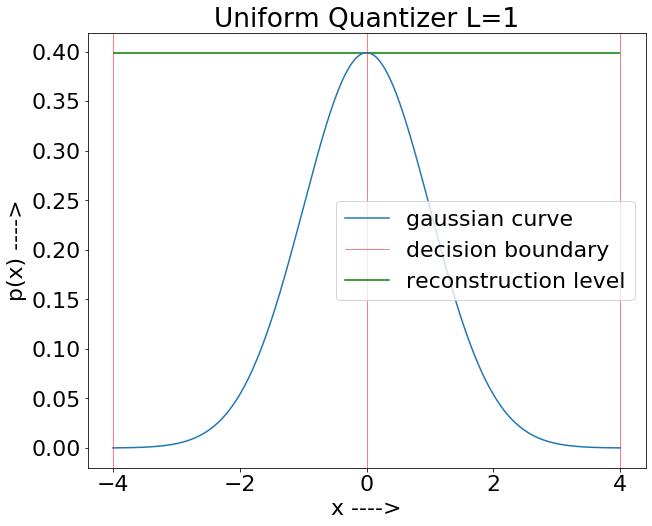

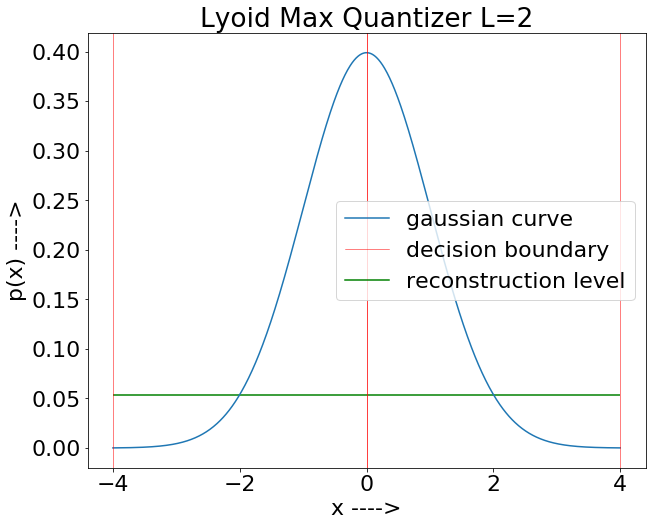

In [86]:
Quantizer(label="Uniform Quantizer L=1", levelToDraw=1)
Quantizer(label="Lyoid Max Quantizer L=2", levelToDraw=2);

#### At L=2 the reconstruction level is at mid-skirt (by horizontal distance) of the bell shape on both side. However, that level around zero is far lower than the peak of the curve by virtue of the bell shape. This is the worst reconstruction that can be made. But at L=1 the reconstruction level is at top of curve which is far better than when at L=2.

## (c-1) Implement  the Llyod-Max  Algorithmto the  PDF  of  (a).  Make  a  new  figure  showing  the  decision  boundaries  and reconstruction levels superimposed on the PDF of (a).

..........

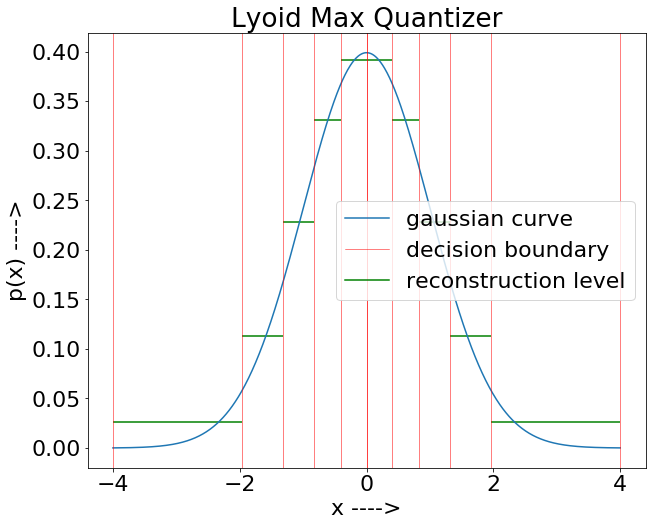

.....................

In [87]:
nonUniQData = Quantizer(LyoidMaxAlgorithm=True, label="Lyoid Max Quantizer")

## (c-2) Vary the number of decision boundaries and plot the quantization error versus the number of quantization levels.

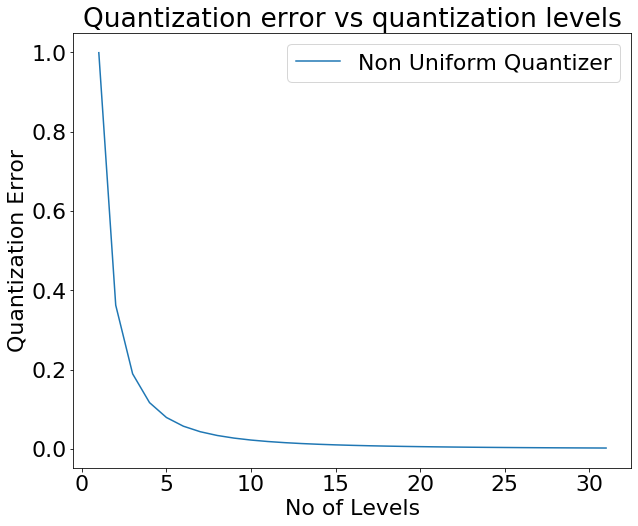

In [88]:
PlotData(nonUniQData, label="Non Uniform Quantizer")

## (d) For both (a) and (b) choose the same number of quantization levels and compare the performance between (a) and (b) in terms of quantization errors.

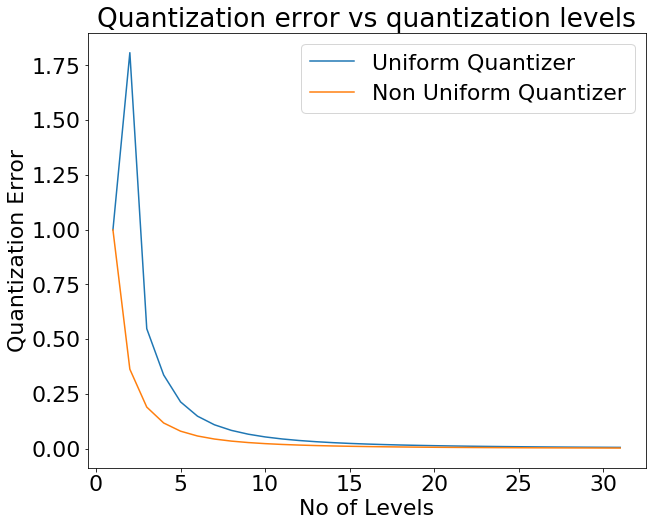

In [89]:
plt.plot([e['M'] for e in uniQuantizerData],[e['error'] for e in uniQuantizerData],label="Uniform Quantizer" )
plt.plot([e['M'] for e in nonUniQData],[e['error'] for e in nonUniQData],label="Non Uniform Quantizer" )
plt.xlabel('No of Levels')
plt.ylabel('Quantization Error')
plt.title('Quantization error vs quantization levels')
plt.legend() ;plt.show()

### (e) Compare your answer with the  values given on pages104 (Table 4.1) and 116 (Table 4.3) of "Fundamentalsof Digital Image Processing" by Anil K. Jain

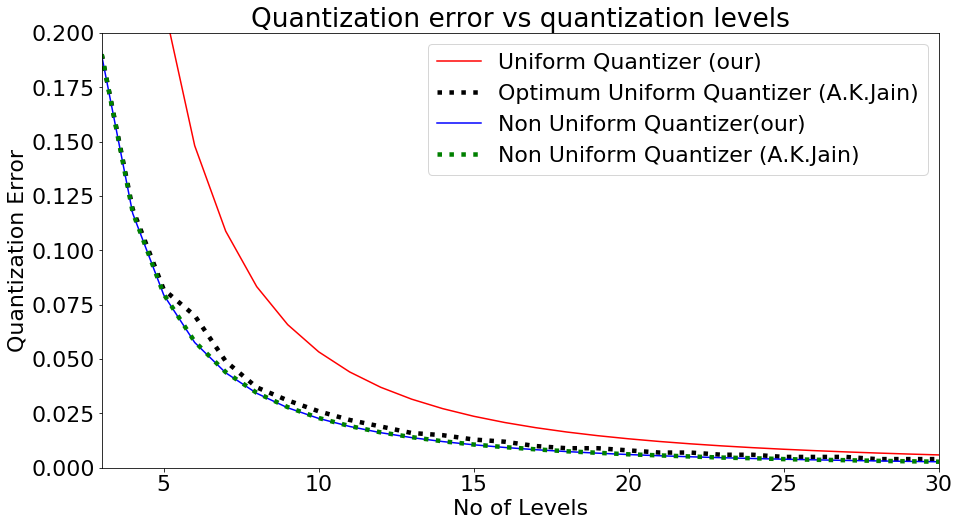

In [90]:
AKJData = genfromtxt('AnilJainTable4.1 and 4.3.csv', delimiter=',') #loading data from CSV file 
plt.figure(figsize=(15,8)) #just setting size of figure
plt.plot([e['M'] for e in uniQuantizerData],[e['error'] for e in uniQuantizerData],color='red',label="Uniform Quantizer (our)" )
plt.plot([e[0] for e in AKJData],[e[2] for e in AKJData], \
         label="Optimum Uniform Quantizer (A.K.Jain)",linewidth=4.5, color='black', linestyle=':')

plt.plot([e['M'] for e in nonUniQData],[e['error'] for e in nonUniQData], color='blue',label="Non Uniform Quantizer(our)" )
plt.plot([e[0] for e in AKJData],[e[1] for e in AKJData], \
         label="Non Uniform Quantizer (A.K.Jain) ",linewidth=4.5, color='green', linestyle=':') 
plt.xlabel('No of Levels')
plt.ylabel('Quantization Error')
plt.title('Quantization error vs quantization levels')
plt.ylim(0.0, 0.2); plt.xlim(3, 30) #limiting boundary on plot
plt.legend() ; plt.show()

## Conclusion

The output seems to be same for both experiments in case of non uniform quantizer.
However,we had taken mid point ( of course non optimal) value between the boundary for Uniform quantizer. On the other hand, Jain had used some optimal value. His result for both uniform and non uniform are comparable. In our case, uniform quantizer is worse than his optimzal uniform quantizer. . . . . .

## Comparing Uniform Quantizer Variants

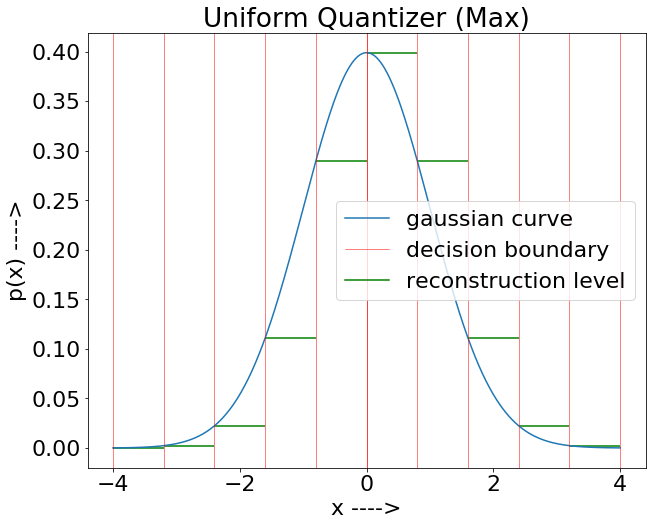

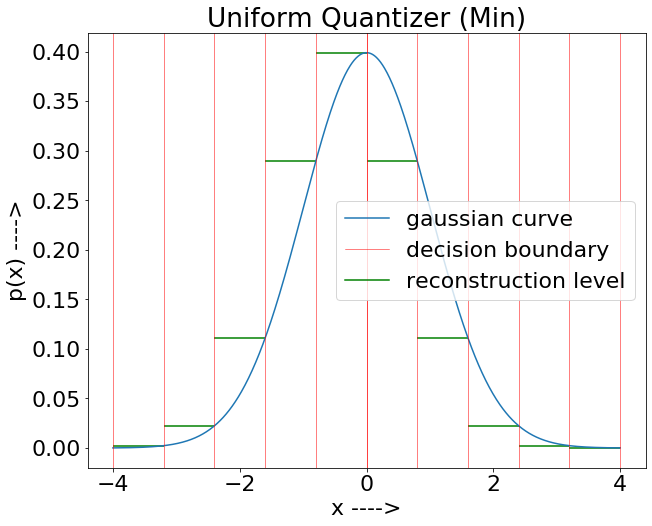

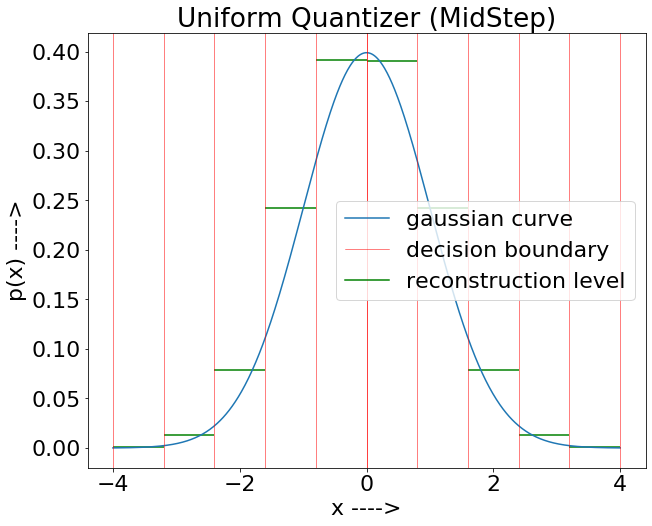

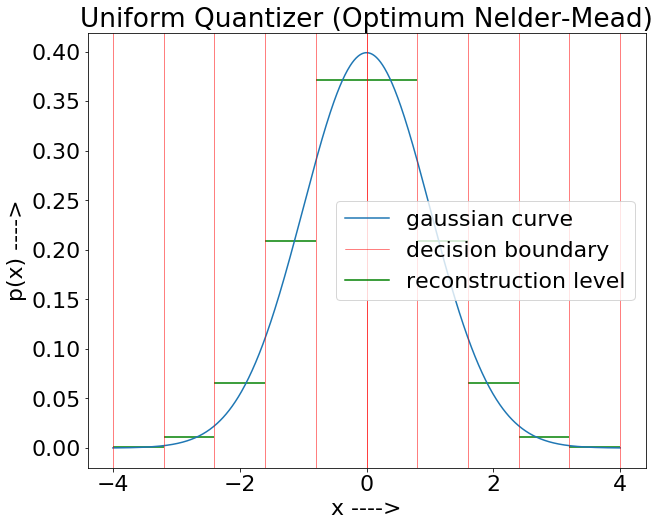

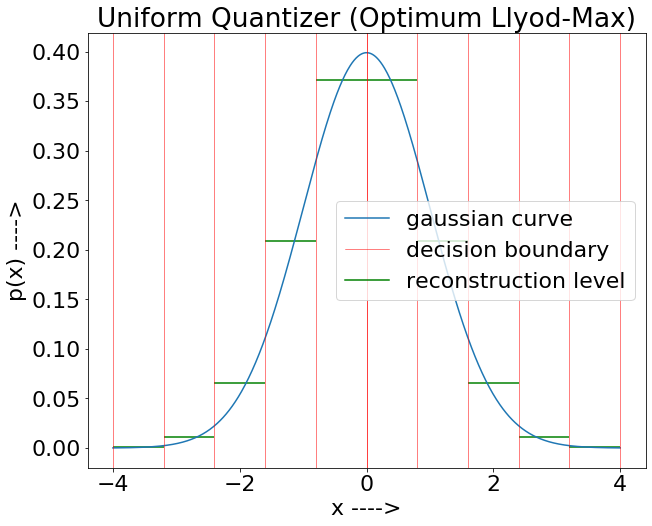

In [91]:
uniQData_max = Quantizer(label="Uniform Quantizer (Max)", UQntType="Max")
uniQData_min = Quantizer(label="Uniform Quantizer (Min)", UQntType="Min")
uniQData_midrise = Quantizer(label="Uniform Quantizer (MidStep)", UQntType="MidStep")
uniQData_optimumN = Quantizer(label="Uniform Quantizer (Optimum Nelder-Mead)", UQntType="OptimumNelder")
uniQData_optYllyod = Quantizer(label="Uniform Quantizer (Optimum Llyod-Max)", UQntType="OptimumYllyod")

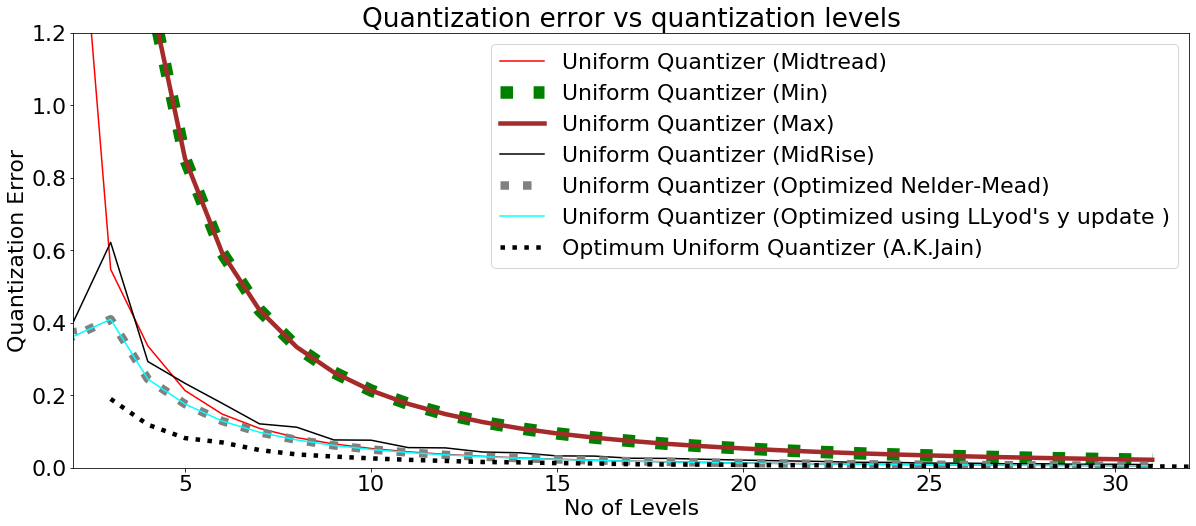

In [107]:
plt.figure(figsize=(20,8))
plt.plot([e['M'] for e in uniQuantizerData],[e['error'] for e in uniQuantizerData],\
         color='red',label="Uniform Quantizer (Midtread)" )
plt.plot([e['M'] for e in uniQData_min],[e['error'] for e in uniQData_min],\
         color='green',linewidth=12.5, linestyle=':',label="Uniform Quantizer (Min)" )
plt.plot([e['M'] for e in uniQData_max],[e['error'] for e in uniQData_max],\
         color='brown',  linewidth=4.5, label="Uniform Quantizer (Max)" )
plt.plot([e['M'] for e in uniQData_midrise],[e['error'] for e in uniQData_midrise],\
         color='black', linewidth=1.5, label="Uniform Quantizer (MidRise)" )
plt.plot([e['M'] for e in uniQData_optimumN],[e['error'] for e in uniQData_optimumN],\
         color='grey', linewidth=8.5, linestyle=':',label="Uniform Quantizer (Optimized Nelder-Mead)" )
plt.plot([e['M'] for e in uniQData_optYllyod],[e['error'] for e in uniQData_optYllyod],\
         color='cyan',label="Uniform Quantizer (Optimized using LLyod's y update )" )
plt.plot([e[0] for e in AKJData],[e[2] for e in AKJData], \
         label="Optimum Uniform Quantizer (A.K.Jain)",linewidth=4.5, color='black', linestyle=':')

plt.xlabel('No of Levels')
plt.ylabel('Quantization Error')
plt.title('Quantization error vs quantization levels')
plt.ylim(0.0, 1.2); 
plt.xlim(2, 32)
plt.legend() ; plt.show()

#### Taking Mid/Max value for optimization didnt give good results and which is obvious. MidTread and MidTread gave almost similar performance. But our MidTread imlementation is simply based on finding 'just greater than' value out of linear space  (for uniformity of fucntion implementation) which might be a reason for zig-zag curve. None of these were a match to Jain's optimal Uniform Quantizer.

#### Also we tested with Nelder-Mead's minimizer for minimizing error function as in Jain's book.  But that was far behind his output. The difference was huge and numerical errors cant be a reason for such. Also we tried to borrow LLyod-Max's second update function. Ironically, the output of both of these methods (Nelder-Mead and LLyod-Max's formula) was SAME.